In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

mean, std = 0.5, 0.5
#mean, std = 0.1307, 0.3081


classes = [0,1,2,3,4,5,6,7,8,9]
instances = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]

train_dataset = loadDataset('SVHN', classes , instances, mode='train')
test_dataset = loadDataset('SVHN', classes , instances, mode='test')


        
n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [5]:
# Set up data loaders
import torch.utils.data
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet(3)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    
    
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/49607 (0%)]	Loss: 2.382792	Accuracy: 9.375
Train: [12800/49607 (26%)]	Loss: 2.538908	Accuracy: 10.0337009804
Train: [25600/49607 (52%)]	Loss: 2.305290	Accuracy: 10.4347153465
Train: [38400/49607 (77%)]	Loss: 2.299666	Accuracy: 10.5649834437
Epoch: 1/20. Train set: Average loss: 2.3612	Accuracy: 10.6517225392
Epoch: 1/20. Validation set: Average loss: 2.2349	Accuracy: 18.5439401535
Train: [0/49607 (0%)]	Loss: 2.250352	Accuracy: 14.453125
Train: [12800/49607 (26%)]	Loss: 2.318539	Accuracy: 10.8915441176
Train: [25600/49607 (52%)]	Loss: 2.280927	Accuracy: 11.7690284653
Train: [38400/49607 (77%)]	Loss: 2.051973	Accuracy: 14.5643625828
Epoch: 2/20. Train set: Average loss: 2.1370	Accuracy: 17.6265446409
Epoch: 2/20. Validation set: Average loss: 1.8220	Accuracy: 25.2072648749
Train: [0/49607 (0%)]	Loss: 1.675771	Accuracy: 34.765625
Train: [12800/49607 (26%)]	Loss: 1.652169	Accuracy: 37.2855392157
Train: [25600/49607 (52%)]	Loss: 1.535193	Accuracy: 40.4509591584
Train: [38400/49607

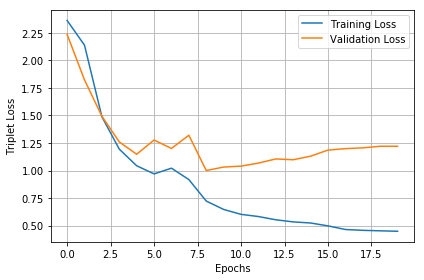

In [6]:
lossDict = fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])
showLossHist(lossDict)

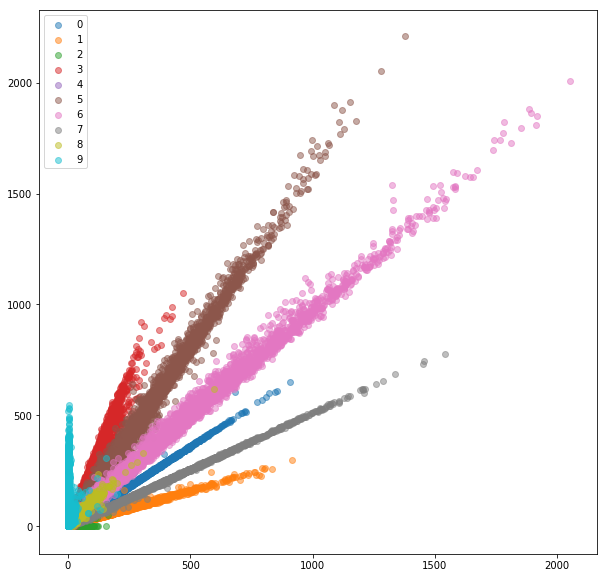

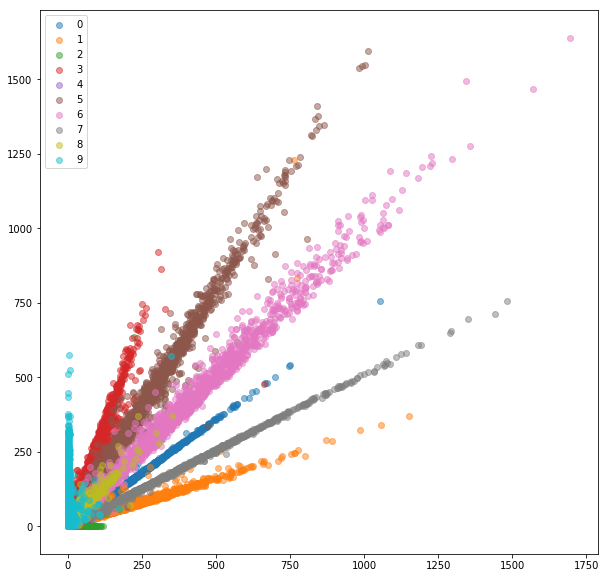

In [7]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [13]:
# Set up data loaders
from datasets import SiameseMNIST, SiameseSVHN

#siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
#siamese_test_dataset = SiameseMNIST(test_dataset)

siamese_train_dataset = SiameseSVHN(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseSVHN(test_dataset)



batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet(3)
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/49607 (0%)]	Loss: 0.248811
Train: [12800/49607 (26%)]	Loss: 0.156616
Train: [25600/49607 (52%)]	Loss: 0.151620
Train: [38400/49607 (77%)]	Loss: 0.152901
Epoch: 1/20. Train set: Average loss: 0.1525
Epoch: 1/20. Validation set: Average loss: 0.1553
Train: [0/49607 (0%)]	Loss: 0.154529
Train: [12800/49607 (26%)]	Loss: 0.149014
Train: [25600/49607 (52%)]	Loss: 0.145044
Train: [38400/49607 (77%)]	Loss: 0.122801
Epoch: 2/20. Train set: Average loss: 0.1307
Epoch: 2/20. Validation set: Average loss: 0.0955
Train: [0/49607 (0%)]	Loss: 0.094332
Train: [12800/49607 (26%)]	Loss: 0.092337
Train: [25600/49607 (52%)]	Loss: 0.083492
Train: [38400/49607 (77%)]	Loss: 0.080751
Epoch: 3/20. Train set: Average loss: 0.0827
Epoch: 3/20. Validation set: Average loss: 0.0761
Train: [0/49607 (0%)]	Loss: 0.073705
Train: [12800/49607 (26%)]	Loss: 0.070638
Train: [25600/49607 (52%)]	Loss: 0.067494
Train: [38400/49607 (77%)]	Loss: 0.065236
Epoch: 4/20. Train set: Average loss: 0.0667
Epoch: 4/20. Valid

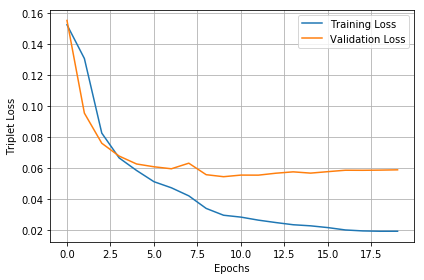

In [14]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

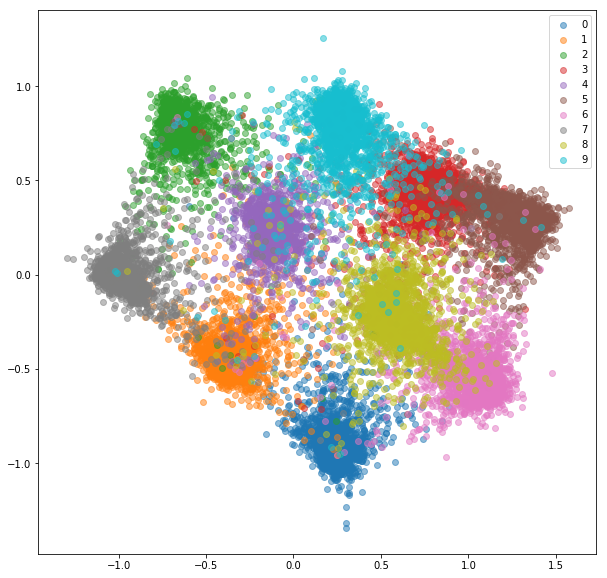

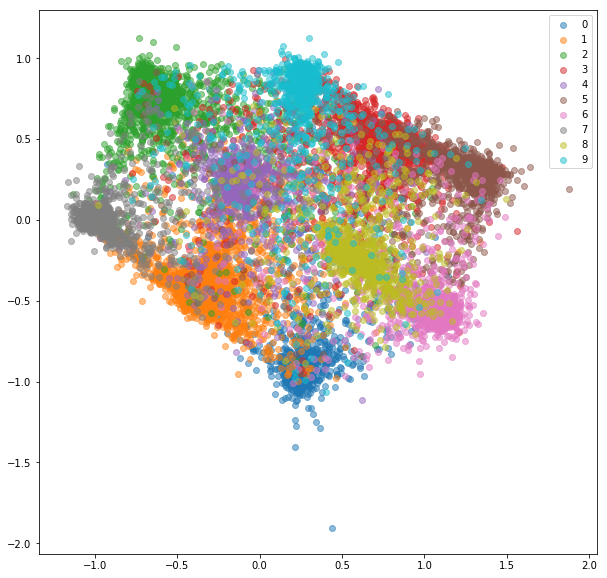

In [15]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [16]:
# Set up data loaders
from datasets import TripletSVHN

triplet_train_dataset = TripletSVHN(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletSVHN(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet(3)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/49607 (0%)]	Loss: 1.000000
Train: [12800/49607 (26%)]	Loss: 1.002328
Train: [25600/49607 (52%)]	Loss: 0.999287
Train: [38400/49607 (77%)]	Loss: 1.000939
Epoch: 1/20. Train set: Average loss: 1.0007
Epoch: 1/20. Validation set: Average loss: 0.9999
Train: [0/49607 (0%)]	Loss: 1.000226
Train: [12800/49607 (26%)]	Loss: 1.000004
Train: [25600/49607 (52%)]	Loss: 1.000242
Train: [38400/49607 (77%)]	Loss: 0.999745
Epoch: 2/20. Train set: Average loss: 0.9998
Epoch: 2/20. Validation set: Average loss: 0.9902
Train: [0/49607 (0%)]	Loss: 0.991819
Train: [12800/49607 (26%)]	Loss: 0.843272
Train: [25600/49607 (52%)]	Loss: 0.678135
Train: [38400/49607 (77%)]	Loss: 0.550902
Epoch: 3/20. Train set: Average loss: 0.6441
Epoch: 3/20. Validation set: Average loss: 0.4731
Train: [0/49607 (0%)]	Loss: 0.444854
Train: [12800/49607 (26%)]	Loss: 0.450535
Train: [25600/49607 (52%)]	Loss: 0.414260
Train: [38400/49607 (77%)]	Loss: 0.392716
Epoch: 4/20. Train set: Average loss: 0.4118
Epoch: 4/20. Valid

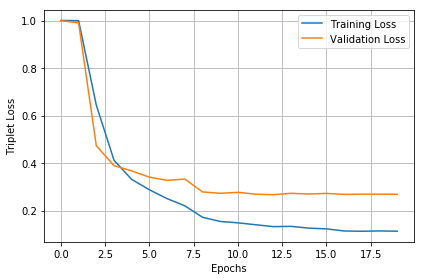

In [17]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

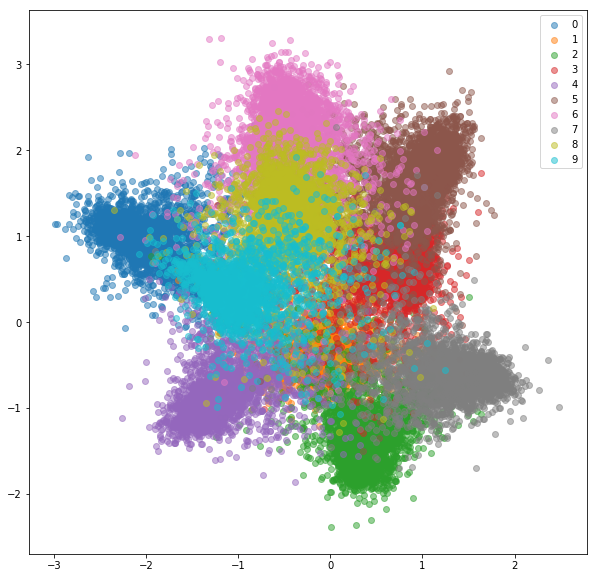

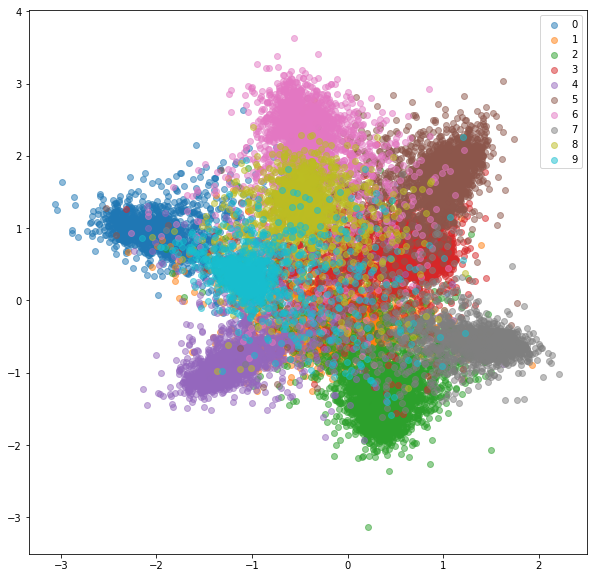

In [18]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

### All positive pairs

In [19]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet(3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/49607 (0%)]	Loss: 0.488419
Train: [12500/49607 (25%)]	Loss: 0.324915
Train: [25000/49607 (51%)]	Loss: 0.295904
Train: [37500/49607 (76%)]	Loss: 0.295631
Epoch: 1/20. Train set: Average loss: 0.3034
Epoch: 1/20. Validation set: Average loss: 0.2894
Train: [0/49607 (0%)]	Loss: 0.287947
Train: [12500/49607 (25%)]	Loss: 0.247303
Train: [25000/49607 (51%)]	Loss: 0.187694
Train: [37500/49607 (76%)]	Loss: 0.165468
Epoch: 2/20. Train set: Average loss: 0.1898
Epoch: 2/20. Validation set: Average loss: 0.1559
Train: [0/49607 (0%)]	Loss: 0.136063
Train: [12500/49607 (25%)]	Loss: 0.141900
Train: [25000/49607 (51%)]	Loss: 0.136535
Train: [37500/49607 (76%)]	Loss: 0.131885
Epoch: 3/20. Train set: Average loss: 0.1345
Epoch: 3/20. Validation set: Average loss: 0.1340
Train: [0/49607 (0%)]	Loss: 0.124392
Train: [12500/49607 (25%)]	Loss: 0.115559
Train: [25000/49607 (51%)]	Loss: 0.116602
Train: [37500/49607 (76%)]	Loss: 0.114347
Epoch: 4/20. Train set: Average loss: 0.1144
Epoch: 4/20. Valid

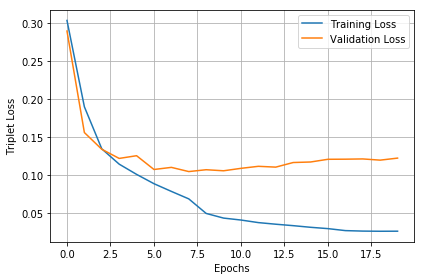

In [20]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

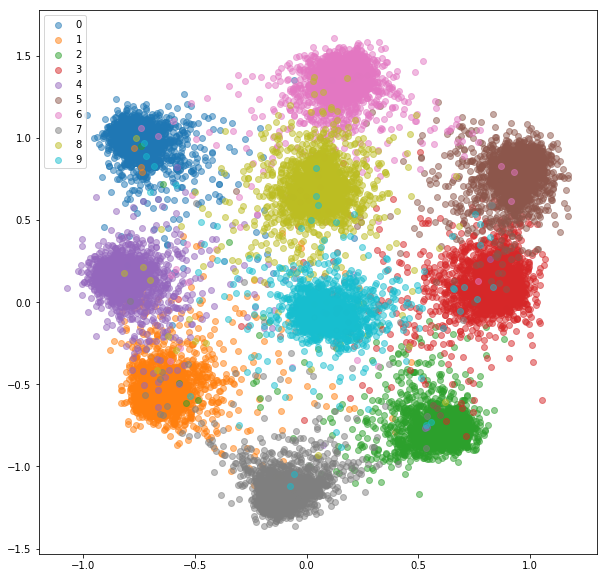

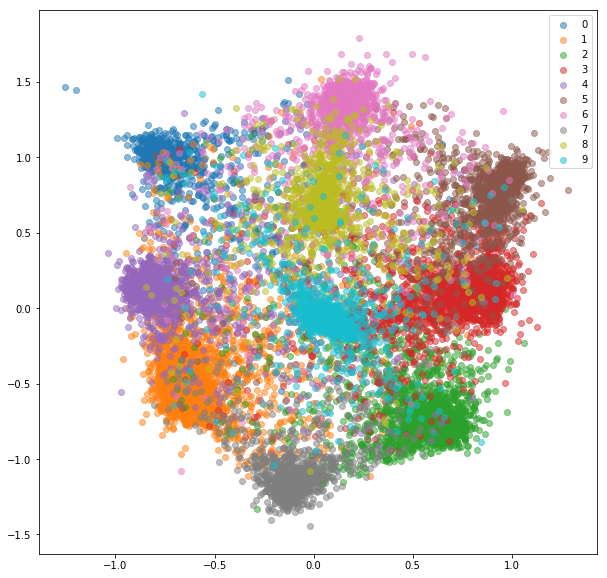

In [21]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Hard negative Pairs

In [22]:
margin = 1.
embedding_net = EmbeddingNet(3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/49607 (0%)]	Loss: 0.497281
Train: [12500/49607 (25%)]	Loss: 0.477346
Train: [25000/49607 (51%)]	Loss: 0.473980
Train: [37500/49607 (76%)]	Loss: 0.453051
Epoch: 1/20. Train set: Average loss: 0.4562
Epoch: 1/20. Validation set: Average loss: 0.4005
Train: [0/49607 (0%)]	Loss: 0.393945
Train: [12500/49607 (25%)]	Loss: 0.376458
Train: [25000/49607 (51%)]	Loss: 0.342971
Train: [37500/49607 (76%)]	Loss: 0.325633
Epoch: 2/20. Train set: Average loss: 0.3371
Epoch: 2/20. Validation set: Average loss: 0.3153
Train: [0/49607 (0%)]	Loss: 0.289402
Train: [12500/49607 (25%)]	Loss: 0.286459
Train: [25000/49607 (51%)]	Loss: 0.257231
Train: [37500/49607 (76%)]	Loss: 0.241639
Epoch: 3/20. Train set: Average loss: 0.2567
Epoch: 3/20. Validation set: Average loss: 0.2825
Train: [0/49607 (0%)]	Loss: 0.169742
Train: [12500/49607 (25%)]	Loss: 0.237711
Train: [25000/49607 (51%)]	Loss: 0.210660
Train: [37500/49607 (76%)]	Loss: 0.190726
Epoch: 4/20. Train set: Average loss: 0.2084
Epoch: 4/20. Valid

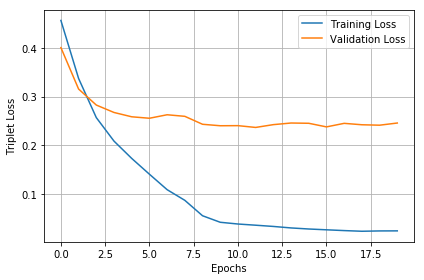

In [23]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

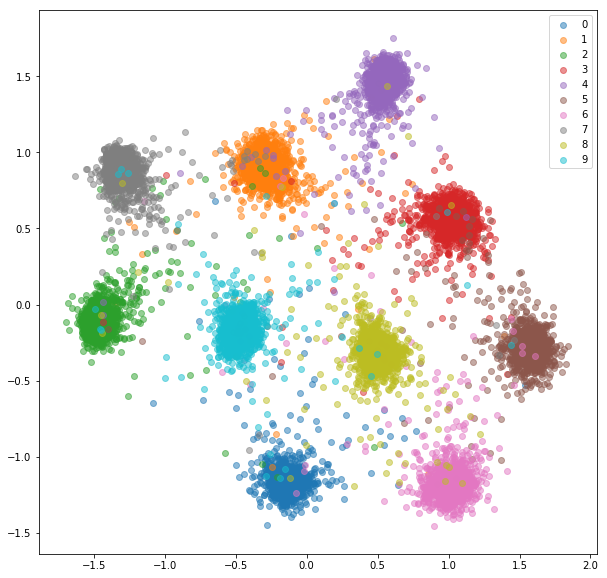

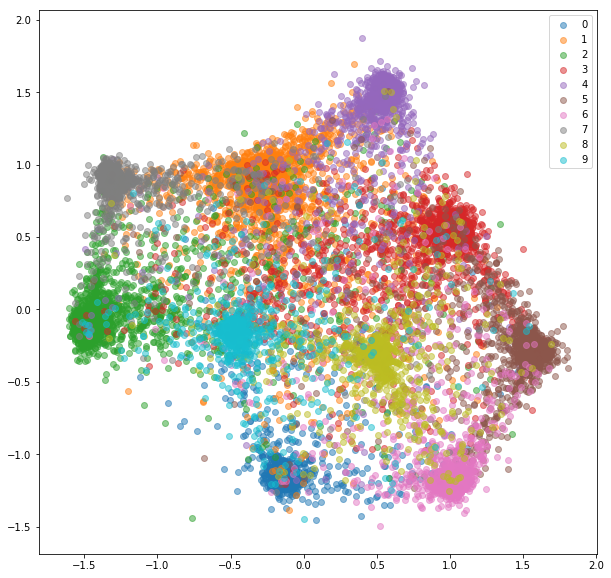

In [24]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

## Online triplet selection

### Random Negative Selection

In [27]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet(3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [26]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/49607 (0%)]	Loss: 0.999998	Average nonzero triplets: 3000.0
Train: [12500/49607 (25%)]	Loss: 1.000040	Average nonzero triplets: 3000.0
Train: [25000/49607 (51%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/49607 (76%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 1/20. Train set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Epoch: 1/20. Validation set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Train: [0/49607 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/49607 (25%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [25000/49607 (51%)]	Loss: 1.000000	Average nonzero triplets: 3000.0


Process Process-215:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
  File "/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Semi hard triplets

In [29]:
margin = 1.
embedding_net = EmbeddingNet(3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(0.1))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

Train: [0/49607 (0%)]	Loss: 0.999940	Average nonzero triplets: 2984.0
Train: [12500/49607 (25%)]	Loss: 0.952129	Average nonzero triplets: 701.450980392
Train: [25000/49607 (51%)]	Loss: 756.977405	Average nonzero triplets: 367.702970297
Train: [37500/49607 (76%)]	Loss: 0.949545	Average nonzero triplets: 295.748344371
Epoch: 1/20. Train set: Average loss: 191.8668	Average nonzero triplets: 246.984848485
Epoch: 1/20. Validation set: Average loss: 0.9501	Average nonzero triplets: 34.1650485437
Train: [0/49607 (0%)]	Loss: 0.947298	Average nonzero triplets: 46.0
Train: [12500/49607 (25%)]	Loss: 0.950084	Average nonzero triplets: 80.6862745098
Train: [25000/49607 (51%)]	Loss: 0.950249	Average nonzero triplets: 63.9702970297
Train: [37500/49607 (76%)]	Loss: 2930.550324	Average nonzero triplets: 55.701986755
Epoch: 2/20. Train set: Average loss: 740.7480	Average nonzero triplets: 64.2474747475
Epoch: 2/20. Validation set: Average loss: 0.9504	Average nonzero triplets: 53.3300970874
Train: [0/49

Train: [0/49607 (0%)]	Loss: 0.948620	Average nonzero triplets: 783.0
Train: [12500/49607 (25%)]	Loss: 0.950105	Average nonzero triplets: 817.568627451
Train: [25000/49607 (51%)]	Loss: 0.950452	Average nonzero triplets: 811.673267327
Train: [37500/49607 (76%)]	Loss: 0.950351	Average nonzero triplets: 808.960264901
Epoch: 18/20. Train set: Average loss: 0.9503	Average nonzero triplets: 806.242424242
Epoch: 18/20. Validation set: Average loss: 0.9503	Average nonzero triplets: 850.980582524
Train: [0/49607 (0%)]	Loss: 0.950947	Average nonzero triplets: 699.0
Train: [12500/49607 (25%)]	Loss: 0.950560	Average nonzero triplets: 817.352941176
Train: [25000/49607 (51%)]	Loss: 0.950379	Average nonzero triplets: 813.386138614
Train: [37500/49607 (76%)]	Loss: 0.950558	Average nonzero triplets: 813.397350993
Epoch: 19/20. Train set: Average loss: 0.9506	Average nonzero triplets: 813.358585859
Epoch: 19/20. Validation set: Average loss: 0.9503	Average nonzero triplets: 850.097087379
Train: [0/49607 

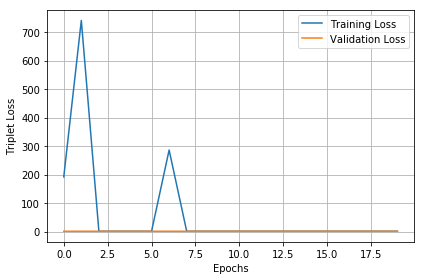

In [30]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

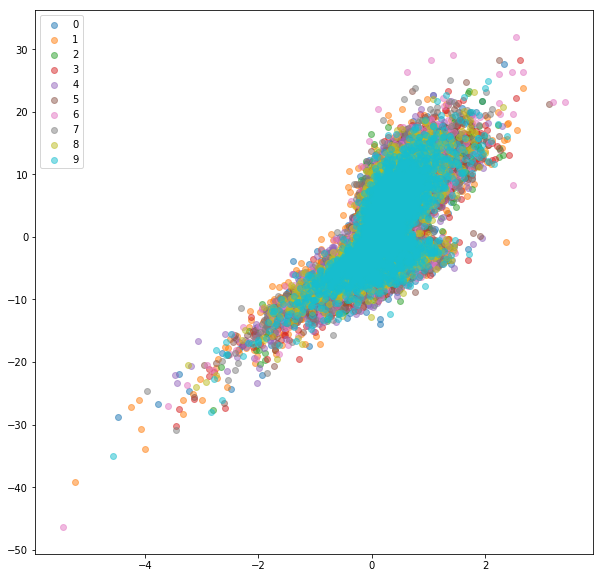

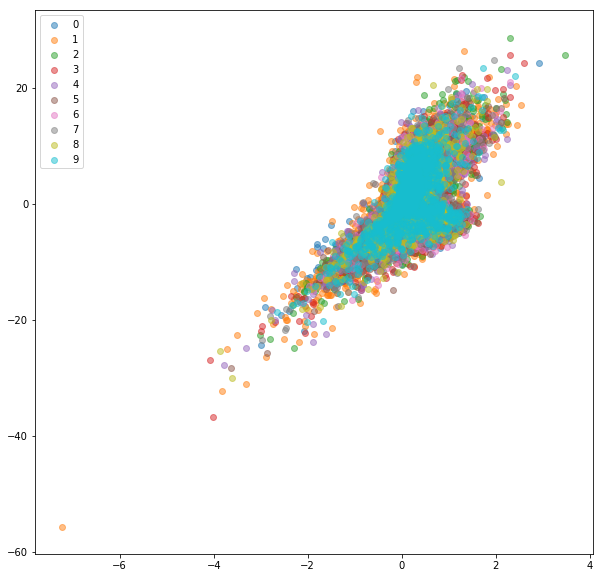

In [31]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Hardest triplet

In [ ]:
margin = 1.
embedding_net = EmbeddingNet(3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(0.1))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

In [ ]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)